 # High level mission design - sanity check
[Link to requirements document](MoonBikeRequirements.ipynb#section_id1)

## Mission duration
In keeping with the spirit of the challenge, all energy used to propel the craft into lunar orbit will come from the pilot. A highly non-conservative assumption of the amount of time it would take a human rider to reach orbital velocity under zero drag conditions would be to divide the final kinetic energy of pilot and craft at orbital velocity by a reasonable output power for an expert cyclist.

In [9]:
import math
power = 250 # watts, approximately the current 24 hour sustained world record
riderMass = 80 # kg
craftMass = 20 # kg
orbitalVelocity = 1680 # m/s
KE = 1/2*(riderMass+craftMass)*orbitalVelocity**2
print('Required duration to reach orbital velocity in hours: ', KE/power/3600)

Required duration to reach orbital velocity in hours:  156.8


This duration far exceeds the capability of an expert cyclist and does not account for any rolling resistance, food, life support, or need to sleep.

By utilizing an electric motor and stored energy to assist the driver, a reasonable mission duration can be achieved while keeping with the spirit of the challenge.

In [4]:
power = 3000 # watts, approximately the current 24 hour sustained world record
orbitalVelocity = 1680 # m/s
KE = 1/2*(riderMass+craftMass)*orbitalVelocity**2
print('Required duration to reach orbital velocity in hours: ', KE/power/3600)

Required duration to reach orbital velocity in hours:  13.066666666666666


This duration is still optimistic, but is the right order of magnitude for a rider to remain pedaling constantly during the mission without the need for rest.

## Required power to reach orbital velocity
On earth, top speed on a bicycle is quickly limited by the power requirements due to aerodynamic drag, which scale with the cube of velocity. On the moon, there is no atmosphere and therefore no aerodynamic drag. There is some amount of dust that can levitate off of the surface due to electrostatic effects, but it will be ignored in the remainder of the analysis under the assumption that the bike will operate on a track some meters of the lunar surface.

When aerodynamic effects are removed, the major remaining losses come from rolling resistance of the bicycle wheels. In order to reduce rolling resistance the bicycle can use larger and stiffer wheels.

In [17]:
#https://en.wikipedia.org/wiki/Rolling_resistance
# rough approximation of the coefficient of rolling resistance for a steel wheel rolling on a steel track
mass = 500 #kg
d = 2.5 #wheel diameter
Crr = 0.0643988/(mass*(d*39.37)**0.25)
print('The coefficient of rolling resistance: ', Crr)
lunarGravity = 1.62 # m/s2
forceRR = Crr*lunarGravity*mass
powerLoss = forceRR*orbitalVelocity
print('The power loss due to rolling resistance is: ', powerLoss, ' watts')


The coefficient of rolling resistance:  4.089134679044131e-05
The power loss due to rolling resistance is:  55.64494471243255  watts


## Wheel rotation speed
A velocity of 1680 m/s is high compared to a standard bicycle ridden on earth.

In [18]:
averageSpeedWinningTourDeFrance = 40/3.6 #kph/3.6 kph/(m/s)
print('Orbital velocity is ',orbitalVelocity/averageSpeedWinningTourDeFrance,' times as fast as the average winning speed for the Tour de France.')

Orbital velocity is  151.20000000000002  times as fast as the average winning speed for the Tour de France.


It is reasonable to be concerned about the wheel rotation speed and strength. Despite orbital velocity greatly exceeding standard bicycle speeds, the resulting rotational speed and centripetal force at the wheel circumferance is not out of the realm of many existing devices.

In [20]:
wheelRotationSpeedRPM = orbitalVelocity/(2*math.pi*d/2)
print('Wheel rotation speed in RPM: ', wheelRotationSpeedRPM*60)
accelerationAtCircumference = orbitalVelocity**2/(d/2)
print('Acceleration at wheel circumference due to rotation: ', accelerationAtCircumference/9.81,'earth g')

Wheel rotation speed in RPM:  12834.25461093044
Acceleration at wheel circumference due to rotation:  230165.13761467888 earth g


This is a high acceleration, but is less than that of an ultracentrifuge rotor (4x higher).

## Staged vs. single stage
By using a staged design, it will be easier to achieve the required speed. Modular battery packs can be ejected after they are depleted.

Battery pack reference: https://chargedevs.com/newswire/gm-reveals-more-technical-details-of-its-ultium-battery-packs/

The following is a description of a feasible battery pack construction.

In [28]:
cellLength = 23*0.0254 #m
cellWidth = 4*0.0254 #m x 
cellHeight = 0.4*0.0254 #m 
cellMass = 3/2.2 #kg
cellCapacity = 0.37 #kWh
cellsPerPack = 10
batteryPackEnergy = cellCapacity*3600*1000*cellsPerPack
additionalMassPerPack = 10
batteryPackMass = cellMass*cellsPerPack+additionalMassPerPack
driveMassPerStage = 0

In [29]:
#orbital velocity at lunar surface
GM_moon = 4.9048695*10**12 # standard gravitational parameter m^3*s^-2
radius_moon = 1738.1*1000 # equatorial radius in meters
orbitalVelocity = math.sqrt(GM_moon/radius_moon)
print('Orbital velocity at the lunar surface is: ',orbitalVelocity,' m/s.')
equatorialCircumferance_moon = radius_moon*2*math.pi
print('Circumferance of the moon at the equator is: ',equatorialCircumferance_moon/1000,' km')

Orbital velocity at the lunar surface is:  1679.872608532767  m/s.
Circumferance of the moon at the equator is:  10920.804382408838  km


In [235]:
import numpy as np
class bike:
    def __init__(self,tireRadius=0.7/2,tireWidth = 0.025, wheelRadius = 0.622/2, mass_wheel_f = 0.66, mass_wheel_r = 0.83, mass_tire_f = 0.24, mass_tire_r = 0.24,mass_frame = 0.8, UCI_max_mass = 6.8, mass_rider = 63, frontalArea = 0.37, CoD = 0.88, density_air = 1.225,gravity=9.81,rollingResistanceCoef = 0.005 ):
        self.tireRadius = tireRadius # UCI limits are 0.55m to 0.7m
        self.tireWidth = tireWidth # UCI maximum is 0.033m
        self.wheelRadius = wheelRadius
        self.mass_wheel_f = mass_wheel_f #kg
        self.mass_wheel_r = mass_wheel_r #kg
        self.mass_tire_f = mass_tire_f#kg
        self.mass_tire_r = mass_tire_r #kg
        self.inertia_f = (self.mass_wheel_f+self.mass_tire_f)*self.wheelRadius**2 #kg*m2
        self.inertia_r = (self.mass_wheel_f+self.mass_tire_f)*self.wheelRadius**2 #kg*m2
        self.mass_frame =mass_frame #kg
        self.UCI_max_mass = UCI_max_mass #kg
        self.mass_UCI_non_rotating = self.UCI_max_mass - (self.mass_wheel_f+self.mass_tire_f + self.mass_wheel_f+self.mass_tire_f)
        self.mass_rider =mass_rider #kg
        self.velocity = 0
        self.mass_bike = self.UCI_max_mass
        self.totalMass = self.mass_rider+self.mass_bike
        self.frontalArea = frontalArea
        self.CoD = CoD
        self.density_air = density_air
        self.gravity = gravity
        self.rollingResistanceCoef = rollingResistanceCoef
    def setVelocity(self,velocity):
        self.velocity = velocity
    def getKineticEnergy(self):
        self.KE = 1/2*self.totalMass*self.velocity**2+1/2*(self.inertia_f+self.inertia_r)*(self.velocity/self.tireRadius)**2
        return self.KE
    def getAeroDragForce(self):
        self.Fd_aero = self.velocity**2*self.density_air*self.CoD*self.frontalArea*0.5
        return self.Fd_aero
    def getRollingDragForce(self):
        self.Fd_rolling = self.rollingResistanceCoef*self.gravity*self.totalMass
        return self.Fd_rolling
    def getDragPower(self):
        self.dragPower = (self.Fd_rolling+self.Fd_aero)*self.velocity
        return self.dragPower

In [236]:
class stageSimulation:
    def __init__(self,totalStoredEnergy,numStages,packMassPerJoule,bike):
        self.totalStoredEnergy = totalStoredEnergy
        self.numStages = numStages
        self.moonBike = bike
        self.packMassPerJoule = packMassPerJoule
        self.batteryPackEnergy = self.totalStoredEnergy/self.numStages
        self.stageMass = self.batteryPackEnergy*packMassPerJoule
        self.GM_moon = 4.9048695*10**12 # standard gravitational parameter m^3*s^-2
        self.radius_moon = 1738.1*1000 # equatorial radius in meters
        self.orbitalVelocity = math.sqrt(self.GM_moon/self.radius_moon)
        self.equatorialCircumferance_moon = self.radius_moon*2*math.pi
        mass = 500 #kg
        d = self.moonBike.tireRadius #wheel diameter
        self.Crr = 0.0643988/(mass*(d*39.37)**0.25)
        
    def simulate(self):
        self.lunarGravity = 1.62 #m/s/s
        self.v = 0
        #print('stage mass:', self.stageMass)
        self.riderMass = 100
        self.time = 0
        self.maxPower = 3000 #watts
        self.usedPackEnergy = 0
        #print('starting mass: ',self.stageMass*self.numStages+self.riderMass+self.moonBike.mass_wheel_f+self.moonBike.mass_wheel_r)
        self.KE = 0
        self.inputMotorSpeed = 4000/60
        self.inputMotorRatedTorque = 15 #Nm
        self.v_rec = np.zeros(self.numStages)
        self.time_rec = np.zeros(self.numStages)
        self.usedPackEnergy_rec = np.zeros(self.numStages)
        self.KE_rec = np.zeros(self.numStages)
        self.approximateDistance = np.zeros(self.numStages)
        self.approximateAcceleration = np.zeros(self.numStages)
        self.normalForcePerAxle = np.zeros(self.numStages)
        self.rollingResistancePower = np.zeros(self.numStages)
        self.netPower = np.zeros(self.numStages)
        self.wheelSpeedHz = np.zeros(self.numStages)
        self.minMotorSpeedPerStage = np.zeros(self.numStages)
        self.maxMotorSpeedPerStage = np.zeros(self.numStages)
        self.torqueLimited = np.zeros(self.numStages)
        self.distance = 0
        self.requiredGearRatio = np.zeros(self.numStages)
        self.torqueToReachApproximateAcceleration = np.zeros(self.numStages)
        self.mass_rec = np.zeros(self.numStages)
        self.remainingEnergy_rec = np.zeros(self.numStages)

        for i in range(self.numStages):
            self.remainingBatteryMass = self.stageMass*(self.numStages-i)
            self.remainingBatteryEnergy = self.batteryPackEnergy*(self.numStages-i)
            self.remainingEnergy_rec[i] = self.remainingBatteryEnergy
            if self.remainingBatteryMass <= 0:
                self.batteryPackEnergy = 0
            self.mass = self.riderMass+self.remainingBatteryMass+self.moonBike.mass_wheel_f+self.moonBike.mass_wheel_r
            self.v = math.sqrt((self.batteryPackEnergy+self.KE)*2/(self.mass+(self.moonBike.inertia_f+self.moonBike.inertia_r)/self.moonBike.tireRadius**2))
            self.KE = 1/2*self.mass*self.v**2+1/2*(self.moonBike.inertia_f+self.moonBike.inertia_r)*(self.v/self.moonBike.tireRadius)**2
            self.usedPackEnergy +=self.batteryPackEnergy
            self.normalForcePerAxle[i] = self.mass/2*(self.lunarGravity-self.v**2/self.radius_moon)
            self.rollingResistancePower[i] = self.Crr*self.normalForcePerAxle[i]*2*self.v
            self.netPower[i] = (self.maxPower-self.rollingResistancePower[i])
            self.timeStage = self.batteryPackEnergy/(self.netPower[i])
            self.time += self.timeStage
            self.wheelSpeedHz[i] = (self.v/(2*math.pi*self.moonBike.tireRadius))
            self.requiredGearRatio[i] =self.inputMotorSpeed/self.wheelSpeedHz[i]

            self.maxMotorSpeedPerStage[i] = (self.v/(2*math.pi*self.moonBike.tireRadius))*self.requiredGearRatio[i]
            self.dV = self.v-self.v_rec[i]
            if i>0:
                self.dD = (self.v_rec[i-1]+self.v)/2*self.timeStage #average speed for stage times stage time
                self.minMotorSpeedPerStage[i] = (self.v_rec[i-1]/(2*math.pi*self.moonBike.tireRadius))*self.requiredGearRatio[i]
            else:
                self.dD = (self.v)/2*self.timeStage #average speed for stage times stage time
            self.distance += self.dD

            self.approximateDistance[i] = self.distance
            self.approximateAcceleration[i] = self.dV/self.time
            self.v_rec[i] = self.v
            self.time_rec[i] = self.time
            self.usedPackEnergy_rec[i] = self.usedPackEnergy
            self.KE_rec[i] = self.KE
            self.torqueToReachApproximateAcceleration[i] = self.approximateAcceleration[i]*self.mass*self.moonBike.tireRadius/self.requiredGearRatio[i]
            self.torqueLimited[i] = self.torqueToReachApproximateAcceleration[i] > self.inputMotorRatedTorque
            self.mass_rec[i] = self.mass
        self.totalPackEnergy = self.numStages*self.batteryPackEnergy
        self.finalKE = 1/2*self.mass*self.v**2+1/2*(self.moonBike.inertia_f+self.moonBike.inertia_r)*(self.v/self.moonBike.tireRadius)**2
        
    def report(self):
        print('starting mass: ', self.stageMass*self.numStages+self.riderMass+self.moonBike.mass_wheel_f+self.moonBike.mass_wheel_r)
        print('final velocity: ',self.v)
        print('total time in hours: ', self.time/3600)
        print('wheel speed in rpm: ',max(self.wheelSpeedHz)*60)
        self.totalPackEnergy = self.numStages*self.batteryPackEnergy
        self.finalKE = 1/2*self.mass*self.v**2+1/2*(self.moonBike.inertia_f+self.moonBike.inertia_r)*(self.v/self.moonBike.tireRadius)**2
        print(self.totalPackEnergy)
        print(self.finalKE)
        print('final KE/totalPackEnergy: ',self.finalKE/self.totalPackEnergy)
        plt.figure()
        plt.title('Moonbike behavior vs time in hours')
        plt.plot(self.time_rec/3600,self.v_rec,label='velocity in m/s')
        plt.plot(self.time_rec/3600,self.usedPackEnergy_rec/100000,label='used pack energy in 100 kwh')
        plt.plot(self.time_rec/3600, self.KE_rec/100000,label='KE of system in 100 kwh')
        plt.plot(self.time_rec/3600,self.approximateDistance/1000/10,label='distance traveled in 10 km')
        plt.plot(self.time_rec/3600,self.approximateAcceleration*10000,label='acceleration in m/s/s time 10000')
        plt.plot(self.time_rec/3600,self.netPower,label='net power in w')
        plt.plot(self.time_rec/3600,self.requiredGearRatio*100,label='required gear ratio times 100')
        plt.legend()
        plt.rcParams['figure.figsize'] = [10, 8]
        print('distance from average acceleration: ',(1/2*np.average(self.approximateAcceleration)*self.time**2)/1000, ' km')
        print('average v: ', np.average(self.v_rec))
        print('distance from average v: ',np.average(self.v_rec)*self.time/1000,' km' )
        print('distance from summing average v per stage times time per stage: ', max(self.approximateDistance/1000),' km')
        print('time to charge packs at 250w pedaling: ',self.usedPackEnergy/250/3600,' hours')
        print('number of "orbits" to reach orbital speed: ',max(self.approximateDistance)/self.equatorialCircumferance_moon)
        print('required gear ratio: ', self.requiredGearRatio)
        print('min motor speed rpm: ', self.minMotorSpeedPerStage*60)
        print('max motor speed rpm: ', self.maxMotorSpeedPerStage*60)
        print('required torque Nm: ', self.torqueToReachApproximateAcceleration)
        print('torque limited in this stage: ', self.torqueLimited)
    def plotMass(self):
        plt.figure()
        title = 'mass - numStages: '+ str(self.numStages)
        plt.title(title)
        plt.plot(self.mass_rec)
    def plotV(self):
        plt.figure()
        title = 'velocity - numStages: '+ str(self.numStages)
        plt.title(title)
        plt.plot(self.v_rec)
    def plotRemainingEnergy(self):
        plt.figure()
        title = 'remaining energy - numStages: '+ str(self.numStages)
        plt.title(title)
        plt.plot(self.remainingEnergy_rec)

### Achieving Orbit

Text(0.5, 1.0, 'Final velocity vs. number of stages')

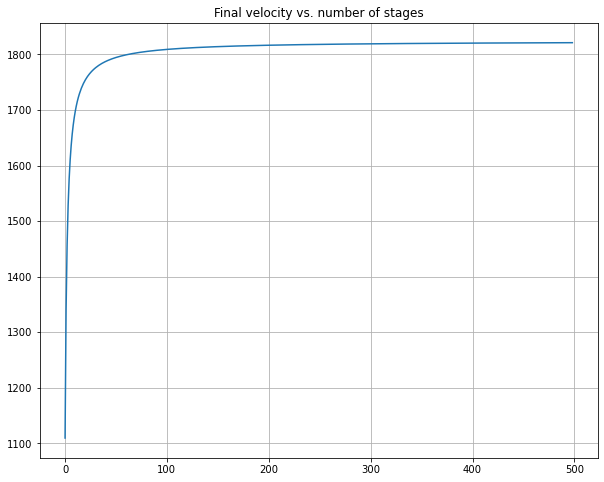

In [242]:
moonBike = bike(tireRadius=2.5/2,tireWidth = 0.025, wheelRadius = 2.45/2, mass_wheel_f = 5, mass_wheel_r = 5)

totalStoredEnergy = 3600*1000*0.37*10*15
numStages = 1
packMassPerJoule = 3/2.2/(3600*1000*0.37)*1
maxStages = 500
stageSweep = []
finalV = []
percentUsedEnergy = []
stages = np.arange(1,maxStages)
for i in stages:
    stageSweep.append(stageSimulation(totalStoredEnergy,i,packMassPerJoule,moonBike))
for sim in stageSweep:
    sim.simulate()
    finalV.append(sim.v)
    percentUsedEnergy.append(sim.usedPackEnergy)
plt.figure()
plt.plot(finalV)
plt.grid()
plt.title('Final velocity vs. number of stages')

### Achieving escape velocity

1.0237510237510236e-06


Text(0.5, 1.0, 'Final velocity vs. number of stages')

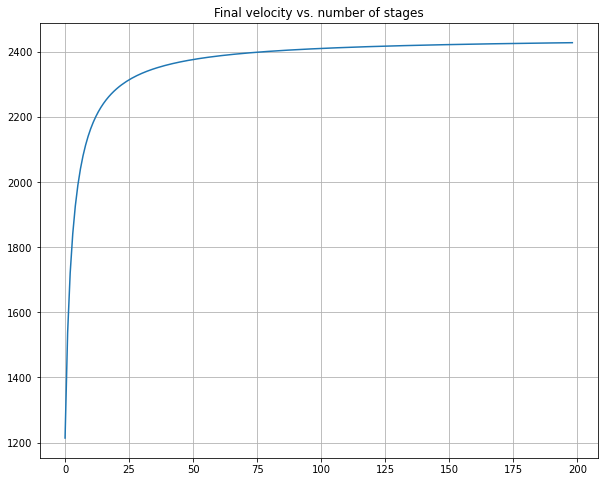

In [252]:
moonBike = bike(tireRadius=2.5/2,tireWidth = 0.025, wheelRadius = 2.45/2, mass_wheel_f = 5, mass_wheel_r = 5)

totalStoredEnergy = 3600*1000*0.37*10*27
numStages = 1
packMassPerJoule = 3/2.2/(3600*1000*0.37)*1
print(packMassPerJoule)
maxStages = 200
stageSweep = []
finalV = []
percentUsedEnergy = []
stages = np.arange(1,maxStages)
for i in stages:
    stageSweep.append(stageSimulation(totalStoredEnergy,i,packMassPerJoule,moonBike))
for sim in stageSweep:
    sim.simulate()
    finalV.append(sim.v)
    percentUsedEnergy.append(sim.usedPackEnergy)
plt.figure()
plt.plot(finalV)
plt.grid()
plt.title('Final velocity vs. number of stages')

In [249]:
print('Mass of batteries in kg/kwh: ',packMassPerJoule*1000*3600)
print('energy density of batteries in kwh/kg: ',1/(packMassPerJoule*1000*3600))

Mass of batteries in kg/kwh:  3.6855036855036847
energy density of batteries in kwh/kg:  0.27133333333333337
